In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
import calendar

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

plt.style.use('Cole_2018.mplstyle')
sns.set_style('whitegrid')

# 1. Load data
* Data was scraped and processed in the previously numbered notebooks

In [2]:
# Load table of fact checks
df_checks = pd.read_csv('/gh/data/politifact/20190701scrape/processed_v2.csv')
df_checks['date'] = pd.to_datetime(df_checks['date'])
df_checks.head()

,name,statement,source,date,finding,comment,article_page,identity_id,truth_score
0,Donald Trump,"""The Obama administration was begging for a me...",PolitiFact National,2019-07-01,False,Obama set high bar for meetings,/truth-o-meter/statements/2019/jul/01/donald-t...,donald-trump,1.0
1,Facebook posts,Six Flags is offering five free passes and unl...,PolitiFact Facebook fact-checks,2019-07-01,False,Summer scam-o-rama,/facebook-fact-checks/statements/2019/jul/01/f...,facebook-posts,1.0
2,Beto O'Rourke,"""The Census is predicting a 6% undercount that...",PolitiFact Texas,2019-07-01,Half-True,Confuses key details,/texas/statements/2019/jul/01/beto-orourke/oro...,beto-orourke,3.0
3,Elizabeth Warren,"""Prison phone companies charge as much as $25 ...",PolitiFact National,2019-07-01,Mostly True,"In some jails, talk isn't cheap",/truth-o-meter/statements/2019/jul/01/elizabet...,elizabeth-warren,4.0
4,Ta-Nehisi Coates,"""The typical black family in this country has ...",PunditFact,2019-07-01,True,Racial gap has persisted for years,/punditfact/statements/2019/jul/01/ta-nehisi-c...,ta-nehisi-coates,5.0


In [3]:
# Load table of fact checks
df_info = pd.read_csv('/gh/data/politifact/20190707scrape_personalities/processed_v2.csv')
df_info.head()

,title,bio,party_title,state,identity_id,name,identity_type
0,Our Texas Values feeds,"Established in 2012, Texas Values is an Austin...",NaN,NaN,texas-values,Texas Values,NaN
1,Democrat from Ohio,Teresa Fedor is a Democrat in the Ohio House o...,D,Ohio,teresa-fedor,Teresa Fedor,NaN
2,Our Susana Mendoza feeds,Susana Mendoza is the Illinois comptroller. Me...,NaN,NaN,susana-mendoza,Susana Mendoza,NaN
3,Republican from Virginia,"Stephen Martin, R-Chesterfield, represents the...",R,Virginia,stephen-martin,Stephen Martin,NaN
4,None from Ohio,Brent Larkin writes a weekly column for The Pl...,NaN,Ohio,brent-larkin,Brent Larkin,NaN


In [4]:
# Merge identity info into fact checks
df = df_checks.merge(df_info, on=['name', 'identity_id'])
df.head()

,name,statement,source,date,finding,comment,article_page,identity_id,truth_score,title,bio,party_title,state,identity_type
0,Donald Trump,"""The Obama administration was begging for a me...",PolitiFact National,2019-07-01,False,Obama set high bar for meetings,/truth-o-meter/statements/2019/jul/01/donald-t...,donald-trump,1.0,Republican from New York,Donald Trump is the president of the United St...,R,New York,person
1,Donald Trump,"California ""admitted"" there were ""a million"" i...",PolitiFact California,2019-06-24,Pants on Fire!,Voter fraud claim remains baseless,/california/statements/2019/jun/24/donald-trum...,donald-trump,0.0,Republican from New York,Donald Trump is the president of the United St...,R,New York,person
2,Donald Trump,"Says the Central Park Five ""admitted their gui...",PolitiFact National,2019-06-24,Mostly False,No confession to the rape itself,/truth-o-meter/statements/2019/jun/24/donald-t...,donald-trump,2.0,Republican from New York,Donald Trump is the president of the United St...,R,New York,person
3,Donald Trump,"""When I became president, President Obama had ...",PolitiFact National,2019-06-21,False,"Repeated claim, still false",/truth-o-meter/statements/2019/jun/21/donald-t...,donald-trump,1.0,Republican from New York,Donald Trump is the president of the United St...,R,New York,person
4,Donald Trump,"""Well, I got 52% (of women voters). And I will...",PolitiFact National,2019-06-20,Mostly False,"Not all women, percent is only for white women",/truth-o-meter/statements/2019/jun/20/donald-t...,donald-trump,2.0,Republican from New York,Donald Trump is the president of the United St...,R,New York,person


# 2. Average truth score for each politician in most popular states

In [5]:
# Determine count and average truth score per person
df_person = df[df['identity_type']=='person']
df_person_avg = df_person.groupby('identity_id')['truth_score'] \
    .agg(['mean', 'count']).reset_index().rename(columns={'mean': 'avg_truth', 'count': 'n_facts'})
df_person_avg = df_person_avg.merge(df_info, on='identity_id')

# only get people with at least 5 fact checks
people_high_checks = df_person_avg[df_person_avg['n_facts'] >= 5]['name']
df_plt = df_person_avg[df_person_avg['name'].isin(people_high_checks)]

# only get states with at least 5 people
states_check_counts = df_plt.groupby('state')['name'].count()
states_high_checks = states_check_counts[states_check_counts >= 5].index
df_plt = df_plt[df_plt['state'].isin(states_high_checks)]
df_plt = df_plt[df_plt['party_title'].isin(['R', 'D'])]
df_plt['party_title'] = df_plt['party_title'].replace({'R': 'Republican', 'D': 'Democrat'})
df_plt.head()

,identity_id,avg_truth,n_facts,title,bio,party_title,state,name,identity_type
0,adam-hasner,3.166667,12,Republican from Florida,"Adam Hasner, R-Delray Beach, is a former Major...",Republican,Florida,Adam Hasner,person
1,adam-putnam,2.812500,16,Republican from Florida,Adam Putnam lost the Republican primary for Fl...,Republican,Florida,Adam Putnam,person
3,alan-grayson,3.176471,34,Democrat from Florida,Alan Grayson was initially elected to Congress...,Democrat,Florida,Alan Grayson,person
4,alberta-darling,2.666667,9,Republican from Wisconsin,"Wisconsin state Sen. Alberta Darling, R-River ...",Republican,Wisconsin,Alberta Darling,person
5,alex-sink,4.000000,19,Democrat from Florida,Alex Sink is a candidate for Congress in Flori...,Democrat,Florida,Alex Sink,person


/Users/scott/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


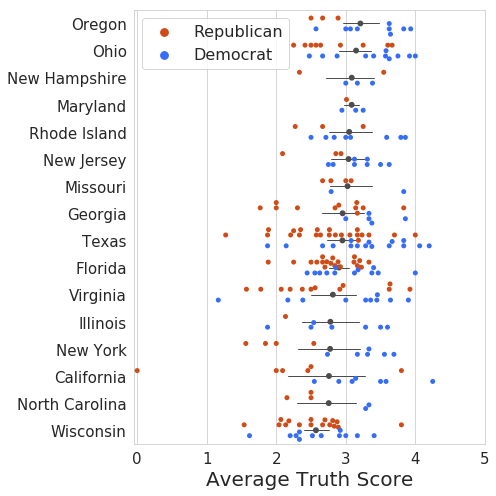

In [6]:
fig = plt.figure(figsize=(7, 7))
sns.swarmplot(x='avg_truth', y='state', data=df_plt, hue='party_title', size=5,
              palette=sns.diverging_palette(20, 260, s=95, l=50, sep=10, n=2, center='dark'),
              hue_order=['Republican', 'Democrat'], dodge=True,
              order=df_plt.groupby('state')['avg_truth'].mean().sort_values(ascending=False).index)
sns.pointplot(x='avg_truth', y='state', data=df_plt,
              color='.3', capsize=0, errwidth=1, scale=.5, linestyles='',
#               plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}, # DOESN'T WORK
              order=df_plt.groupby('state')['avg_truth'].mean().sort_values(ascending=False).index)

# # Change transparency
# ax = plt.gca()
# if i > 0:
#     [i.set_alpha(.5) for i in ax.collections]
#     [i.set_alpha(.5) for i in ax.lines]

plt.legend(fontsize=16, title='')
plt.xlabel('Average Truth Score')
plt.ylabel('')
plt.xlim((-.05,5))
plt.xticks(np.arange(0,6))
plt.tight_layout()
plt.savefig('/gh/srcole.github.io/assets/politifact/20_truth_by_state_and_party.png')